In [103]:
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# fix random seed for reproducibility
numpy.random.seed(42)

In [96]:
# Read in partial dataset for debugging
input_file = "/data/scratch/rcurrie/tumor_normal.h5"
X = HDF5Matrix(input_file, 'X', start=0, end=19000)
y = HDF5Matrix(input_file, 'y', start=0, end=19000)
classes = HDF5Matrix(input_file, 'classes', start=0, end=19000)

In [97]:
# Split into stratified training and test sets
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(X, classes):
    X_train, X_test = X.data.value[train_index], X.data.value[test_index]
    y_train, y_test = y.data.value[train_index], y.data.value[test_index]
    classes_train, classes_test = classes.data.value[train_index], classes.data.value[test_index]

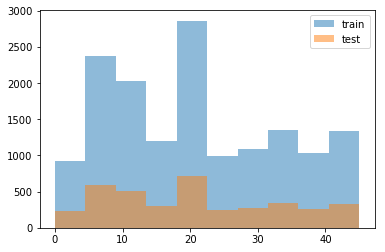

In [98]:
# Plot relative amount in each class
import random
import numpy
from matplotlib import pyplot
pyplot.hist(classes_train, alpha=0.5, label='train')
pyplot.hist(classes_test, alpha=0.5, label='test')
pyplot.legend(loc='upper right')
pyplot.show()

In [99]:
from keras.layers import Dense, Activation

model = Sequential()

# ~600 genes in cancer http://cancer.sanger.ac.uk/census/
model.add(Dense(600, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [104]:
X_train.shape

(15200, 19126)

In [100]:
model.fit(X_train, y_train, epochs=5, shuffle='batch', batch_size=32)

Epoch 1/5
15200/15200 [==============================] - 243s - loss: 7.9092 - acc: 0.5083     

In [101]:
model.evaluate(X_test, y_test, batch_size=32)

3776/3800 [============================>.] - ETA: 0s 

[7.2870758428071678, 0.54789473696758872]